# Model Training & Evaluation

In [1]:
from torchinfo import summary

import optuna

from leaknet.model import LeakNet
from leaknet.dataset import LeakNetDataModule
from leaknet.visualize import *
from leaknet.config import *
from leaknet.utils import set_device, set_seed

import lightning as L
import torch
import logging
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)

from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend
from optuna.trial import Trial

from os import path

set_device()
seed = set_seed()

Using device = cpu
Using seed = 42


In [3]:
model_filename = LeakNet.predict_step.__code__.co_filename

## Training

In [203]:
model = LeakNet(2, aggregation_func="logavgexp", d_attn=8, learning_rate=3e-4, regularization_weight=1e-4, dropout=0.1, apply_positional_encoding=True)
dm = LeakNetDataModule()
summary(model, input_data=next(iter(dm.test_dataloader()))[0])


Layer (type:depth-idx)                        Output Shape              Param #
LeakNet                                       [1, 1]                    --
├─FCNFeatureExtractor: 1-1                    [1, 16, 100]              --
│    └─Sequential: 2-1                        [1, 16, 100]              --
│    │    └─ConvBlock: 3-1                    [1, 16, 100]              304
│    │    └─ConvBlock: 3-2                    [1, 32, 100]              2,656
│    │    └─ConvBlock: 3-3                    [1, 16, 100]              1,584
├─MILConjunctivePooling: 1-2                  [1, 100, 1]               1
│    └─PositionalEncoding: 2-2                [1, 100, 16]              --
│    └─Dropout: 2-3                           [1, 100, 16]              --
│    └─Sequential: 2-4                        [1, 100, 1]               --
│    │    └─Linear: 3-4                       [1, 100, 8]               136
│    │    └─Tanh: 3-5                         [1, 100, 8]               --
│    │    └─L

In [167]:
class MetricTracker(L.Callback):

  def __init__(self):
    self.history = {
      "epoch": [],
      "train_loss": [],
      "val_loss": []
    }

  def on_train_epoch_end(self, trainer, pl_module):
    train_loss = trainer.callback_metrics.get("loss")
    self.history['train_loss'].append(train_loss.item())
    self.history['epoch'].append(trainer.current_epoch + 1)

  def on_validation_epoch_end(self, trainer: L.Trainer, module):
    logs = trainer.logged_metrics
    logs = {k: v.item() if isinstance(v, torch.Tensor) else v for k, v in logs.items()}
    
    for k, v in logs.items():
      if k not in self.history:
        self.history[k] = []
      self.history[k].append(v)

In [168]:
class PruningCallback(L.Callback):
    def __init__(self, trial: Trial):
        self.trial = trial
    
    def on_validation_epoch_end(self, trainer, pl_module):
        self.trial.report(trainer.logged_metrics['val_loss'], trainer.current_epoch)
        
        if self.trial.should_prune():
            raise optuna.TrialPruned()
    

In [ ]:


def objective_leaknet(trial):
    
    lr = trial.suggest_float('learning_rate', 1e-4, 1, log=True)
    aggregation_func = trial.suggest_categorical('aggregation_func', ["logavgexp", "mean"])
    reg_weight = trial.suggest_float('regularization_weight', 1e-6, 1e-3, log=True)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    d_attn = trial.suggest_int('d_attn', 8, 32, step=8)
    apply_positional_encoding = trial.suggest_categorical('apply_positional_encoding', [True, False])
    
    # Get data loaders
    dm = LeakNetDataModule()
    
    # define model
    model = LeakNet(
        dm.n_features,
        aggregation_func=aggregation_func,
        learning_rate=lr,
        regularization_weight=reg_weight,
        dropout=dropout,
        d_attn=d_attn,
        apply_positional_encoding=apply_positional_encoding
    )
    
    metric_tracker = MetricTracker()
    
    trainer = L.Trainer(
        max_epochs=EPOCHS,
        enable_model_summary=False,
        accelerator="auto",
        devices=1,
        num_sanity_val_steps=0,
        enable_checkpointing=False,
        callbacks=[metric_tracker],
        enable_progress_bar=False
    )
    
    trainer.fit(model, dm)
    
    model_path = path.join(CHECKPOINTS_DIR, f"{trial.study.study_name}_trial_{trial.number}.pt")
    
    trainer.save_checkpoint(model_path)
    
    trial.set_user_attr("history", metric_tracker.history)
    trial.set_user_attr("model_path", model_path)
    
    return metric_tracker.history['val_loss'][-1], metric_tracker.history['mFPR@[0.5:0.95, 30]'][-1]


In [4]:
storage = JournalStorage(JournalFileBackend("optuna_journal.log"))

In [ ]:
optuna.delete_study(study_name="LeakNet", storage=storage)

In [209]:
study = optuna.create_study(
    study_name="LeakNet2",
    storage=storage,
    directions=["minimize", "minimize"],
    sampler=optuna.samplers.TPESampler(seed=seed),
    # pruner=optuna.pruners.HyperbandPruner(max_resource=EPOCHS)
)

[I 2025-04-28 19:47:15,351] A new study created in Journal with name: LeakNet2


In [210]:
study.optimize(objective_leaknet, n_trials=30, n_jobs=-1)

/home/nikas/Projects/irrigo/leaknet/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/nikas/Projects/irrigo/leaknet/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/nikas/Projects/irrigo/leaknet/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
[I 2025-04-28 19:56:56,656] Trial

In [5]:
study = optuna.load_study(study_name="LeakNet2", storage=storage)

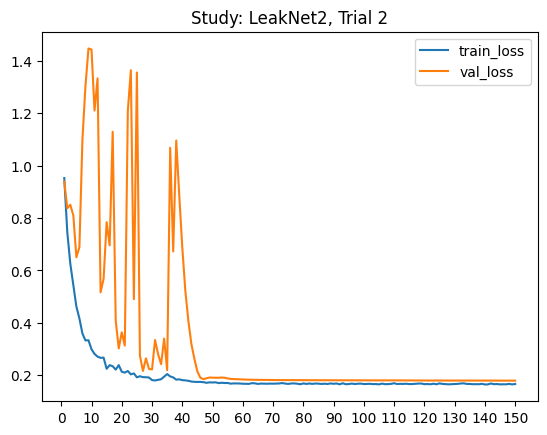

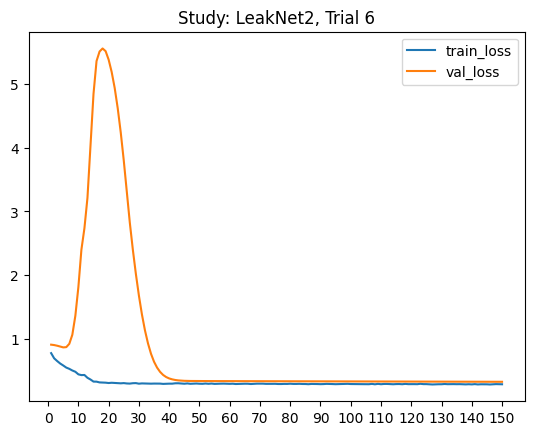

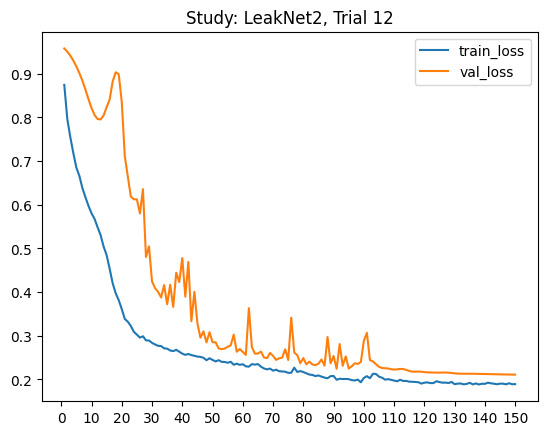

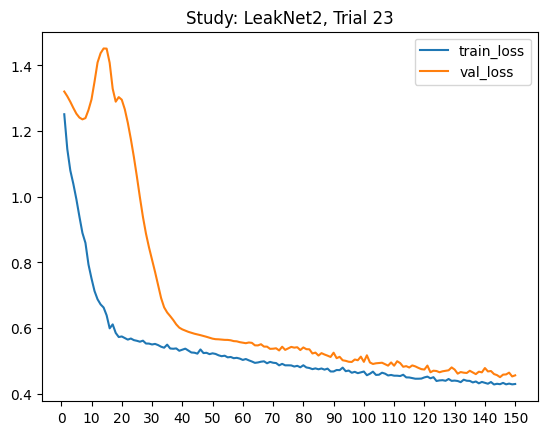

In [6]:
plot_history_from_study(study, ["train_loss", "val_loss"])

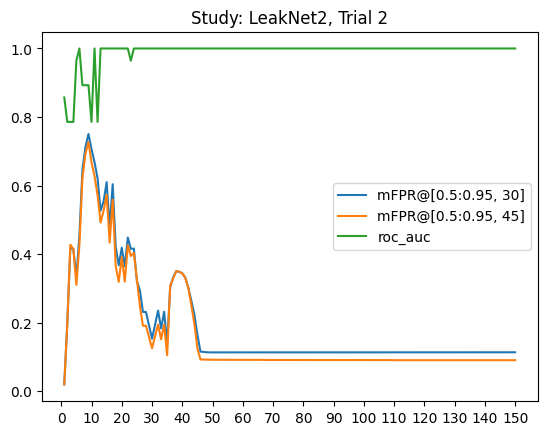

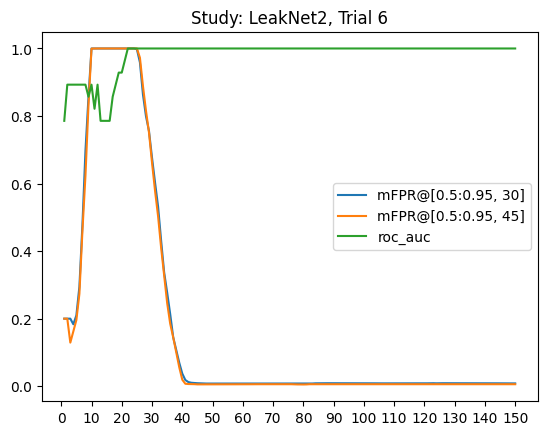

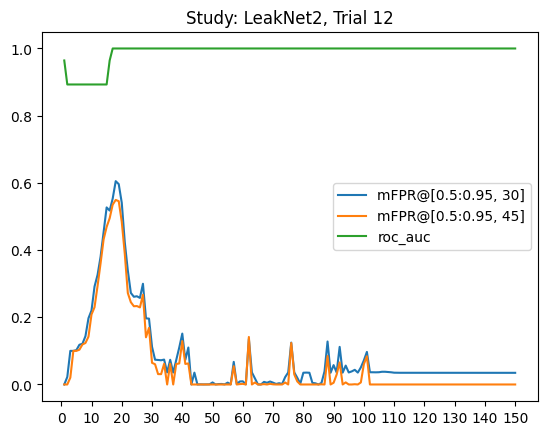

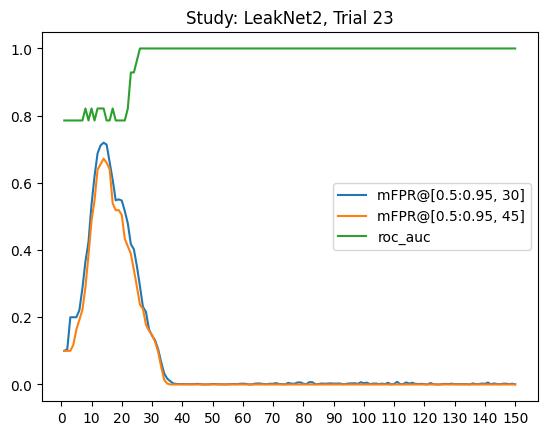

In [7]:
plot_history_from_study(study, ["mFPR@[0.5:0.95, 30]", "mFPR@[0.5:0.95, 45]", "roc_auc"])

In [6]:
trial = study.best_trials[1]

In [ ]:
best_model_history = trial.user_attrs["history"]
model = LeakNet.load_from_checkpoint(trial.user_attrs["model_path"])
model.eval()

LeakNet(
  (feature_extractor): FCNFeatureExtractor(
    (instance_encoder): Sequential(
      (0): ConvBlock(
        (conv_block): Sequential(
          (0): Conv1d(2, 16, kernel_size=(8,), stride=(1,), padding=same, padding_mode=replicate)
          (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (1): ConvBlock(
        (conv_block): Sequential(
          (0): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=same, padding_mode=replicate)
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (2): ConvBlock(
        (conv_block): Sequential(
          (0): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=same, padding_mode=replicate)
          (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
    )
  )
  (classification_pooling): MILC

/home/nikas/Projects/irrigo/leaknet/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


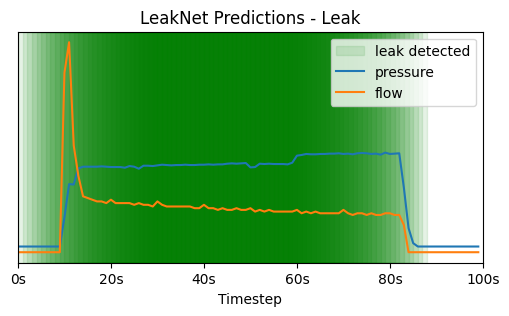

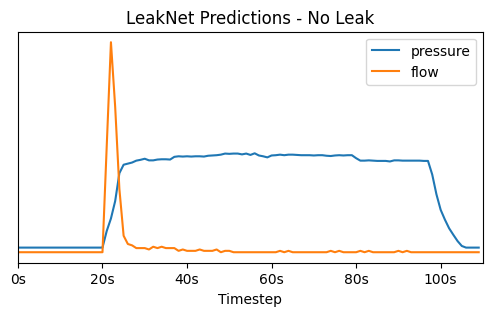

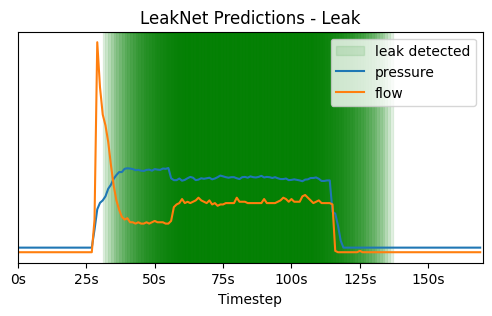

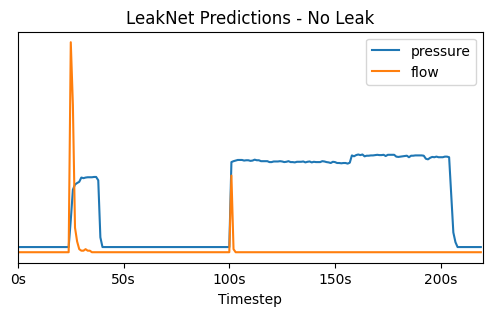

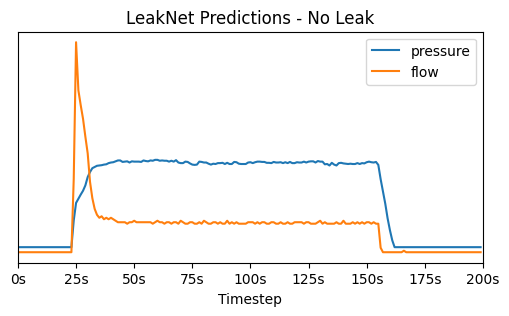

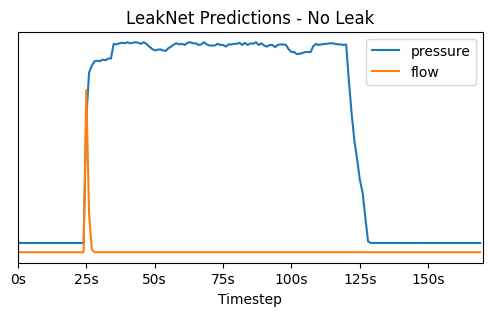

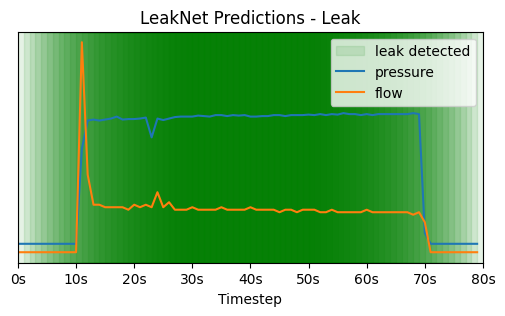

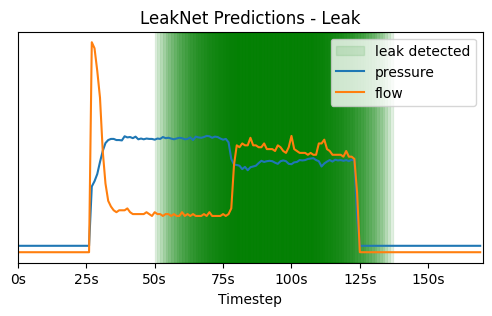

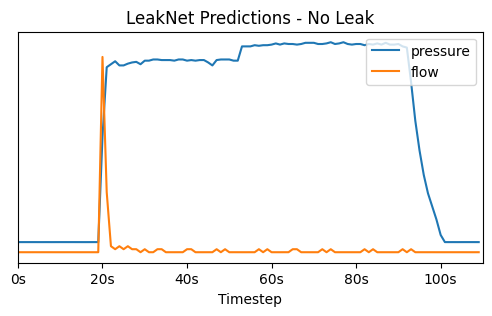

[{}]

In [ ]:
dm = LeakNetDataModule()
trainer = L.Trainer(enable_progress_bar=False)
trainer.test(model, datamodule=dm)

In [ ]:
production_model_path = path.join(MODELS_DIR, "leaknet.pt")
print(f"Saving model to {production_model_path}")
model.to_torchscript(method="script", file_path=production_model_path)

Saving model to /home/nikas/Projects/irrigo/leaknet/models/leaknet.pt
